# Notebook 031: Decision Trees using final predictor set

This notebook contains a decision tree crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'


In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)



%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed\X_train.csv
	../data/raw\shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [4]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [5]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [6]:
#X_train_labels.columns
#X_train.columns

X_train.head(3)

,streetlights-night,lat,lon,night,tempavg,windavg,precip,snowfall,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,college-near,highschool-near,median-age,median-income,poverty-rate,less-than-high-school-perc,bachelor-degree-or-more-perc,enrolled-college-perc,commercial-mix-ratio,industrial-mix-ratio,owner-occupied-ratio,residential-median-value,residential-gini-coef,commercial-mix-ratio-3yr-cagr,industrial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-gini-coef-3yr-cagr,residential-median-value-3yr-cagr
0,0,42.342850,-71.065162,0,5.0,9.2,0.00,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,35.0,86994.80,0.196298,0.114807,0.657709,0.538266,0.151791,0.018597,0.529262,537400.0,0.414893,0.143281,0.225708,-0.061635,0.112333,0.044979
1,0,42.356618,-71.051939,0,19.4,6.8,0.37,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,33.0,67367.09,0.211731,0.186194,0.612408,0.841466,0.663598,0.003558,0.319520,834800.0,0.491992,-0.016317,-0.041497,-0.065097,0.058173,0.046604
2,0,42.378461,-71.033457,0,23.3,10.4,0.08,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,34.0,52935.36,0.202743,0.313648,0.228180,0.253577,0.046684,0.001368,0.451169,359650.0,0.157493,-0.032536,0.020267,-0.021373,0.009573,0.155938


In [7]:
# Examine data

print(f"{len(X_train)} training samples, {len(X_test)} test samples")
print("\nColumns:")
print(', '.join(X_train.columns))

128352 training samples, 32088 test samples

Columns:
streetlights-night, lat, lon, night, tempavg, windavg, precip, snowfall, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, college-near, highschool-near, median-age, median-income, poverty-rate, less-than-high-school-perc, bachelor-degree-or-more-perc, enrolled-college-perc, commercial-mix-ratio, industrial-mix-ratio, owner-occupied-ratio, residential-median-value, residential-gini-coef, commercial-mix-ratio-3yr-cagr, industrial-mix-ratio-3yr-cagr, owner-occupied-ratio-3yr-cagr, residential-gini-coef-3yr-cagr, residential-median-value-3yr-cagr


# Fit a decision tree model to the training set

In [8]:
depths = list(range(1, 20))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for d in depths:
        dtree = DecisionTreeClassifier(max_depth=d)
        dtree.fit(X_train, y_train)
        
        train_score =  dtree.score(X_train, y_train)  # fit and score
              
        cvscores = cross_val_score(dtree, X_train, y_train, cv = 5)  # return list of 5 scores
        # print(cvscores)  #display cv score for each fold (for testing)
        cvmean = cvscores.mean()  # mean of scores
        cvstd = cvscores.std()  # std of scores
        
        # store appropriate values in list the function will return
        train_scores.append(train_score)
        cvmeans.append(cvmean)
        cvstds.append(cvstd)
        
    # end of your code here
    return cvmeans, cvstds, train_scores

In [9]:
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

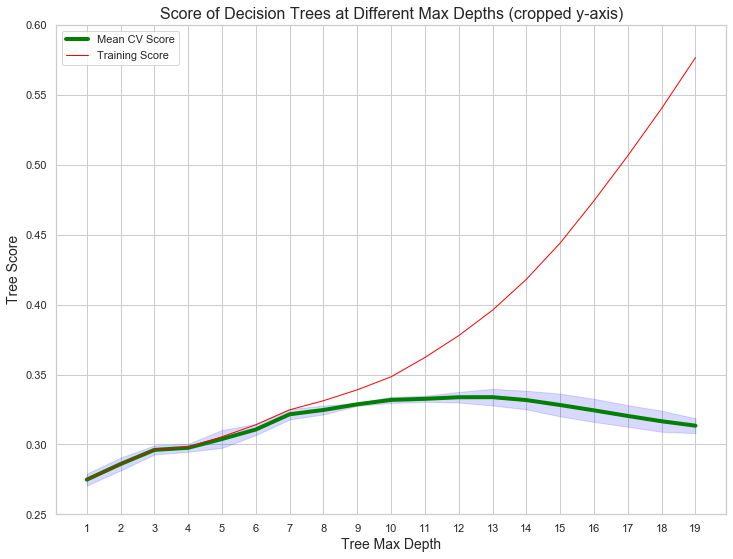

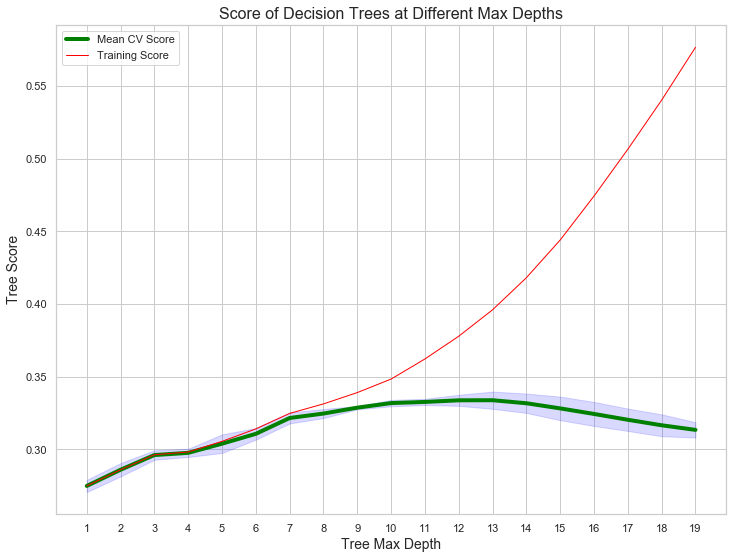

In [10]:
# add two values from a list (https://stackoverflow.com/questions/28036309)
highstd = [cvmeans[d] + 2*cvstds[d] for d in range(len(cvmeans))]
lowstd = [cvmeans[d] - 2*cvstds[d] for d in range(len(cvmeans))]


# cropped y-axis to focus only on CV scores
plt.figure(figsize=(12,9))
plt.plot(depths, cvmeans, label='Mean CV Score', linewidth=4, color='green')
plt.plot(depths, train_scores, label='Training Score', linewidth=1, color='red')
plt.fill_between(depths, highstd, lowstd, color='blue', alpha=0.15)

plt.xlabel('Tree Max Depth', fontsize=14)
plt.xticks(depths)  # by default was displaying every 2.5 so forcing line at each depth
plt.ylabel('Tree Score', fontsize=14)
plt.ylim([0.25,0.60])
plt.title('Score of Decision Trees at Different Max Depths (cropped y-axis)', fontsize=16)
plt.legend()
plt.show()


# y-axis not restricted so both curves are fully visible
plt.figure(figsize=(12,9))
plt.plot(depths, cvmeans, label='Mean CV Score', linewidth=4, color='green')
plt.plot(depths, train_scores, label='Training Score', linewidth=1, color='red')
plt.fill_between(depths, highstd, lowstd, color='blue', alpha=0.15)

plt.xlabel('Tree Max Depth', fontsize=14)
plt.xticks(depths)  # by default was displaying every 2.5 so forcing line at each depth
plt.ylabel('Tree Score', fontsize=14)
plt.title('Score of Decision Trees at Different Max Depths', fontsize=16)
plt.legend()
plt.show()

# Classification Accuracy & Top Predictors

In [11]:
best_cv_tree = DecisionTreeClassifier(max_depth=11)  
best_cv_tree.fit(X_train, y_train)

best_cv_tree_train_score = best_cv_tree.score(X_train, y_train) 
best_cv_tree_test_score = best_cv_tree.score(X_test, y_test) 

print('Accuracy of best CV tree model (Train):', best_cv_tree_train_score)
print('Accuracy of best CV tree model (Test): ', best_cv_tree_test_score)    

Accuracy of best CV tree model (Train): 0.36221484667165293
Accuracy of best CV tree model (Test):  0.33582647718773373


In [12]:
tree1 = DecisionTreeClassifier(max_depth=11)  
tree1.fit(X_train, y_train)

tree1_train_pred = tree1.predict(X_train) 
tree1_test_pred = tree1.predict(X_test) 

# using accuracy_score rather than model.score(X,y) because have predictions
tree1_train_score = accuracy_score(y_train, tree1_train_pred)
tree1_test_score = accuracy_score(y_test, tree1_test_pred)

print('Accuracy of tree1 model (Train):', tree1_train_score)
print('Accuracy of tree1 model (Test): ', tree1_test_score)




Accuracy of tree1 model (Train): 0.36219147344801794
Accuracy of tree1 model (Test):  0.3360446272749938


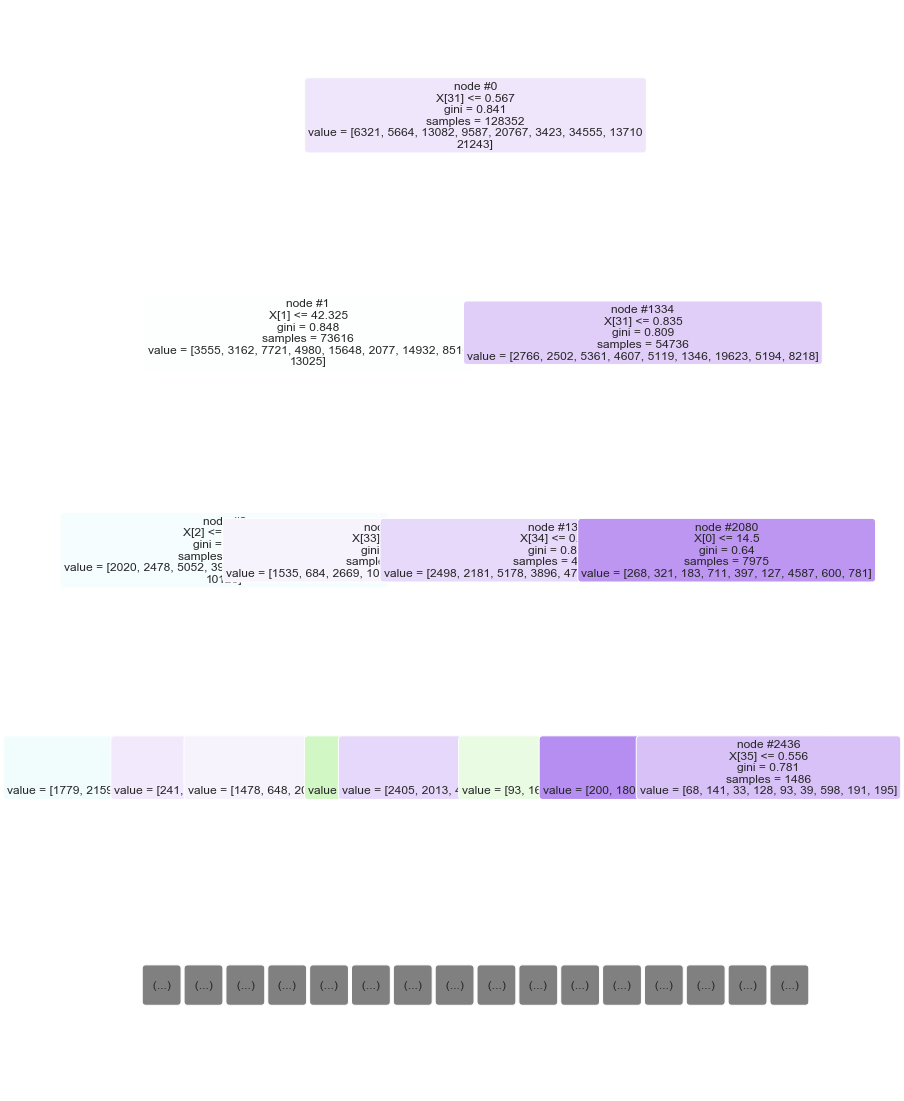

In [13]:
from sklearn import tree

plt.figure(figsize=(12,20))
tree.plot_tree(tree1, filled=True, impurity=True, node_ids=True, rounded=True,fontsize=12, max_depth = 3)
plt.show()

In [14]:
predictors_df = pd.DataFrame(data = [X_train.columns, tree1.feature_importances_],
index = ["feature_importance","importance"]).T

predictors_df = predictors_df.sort_values(by=['importance'],ascending=False)
predictors_df.head(6)


,feature_importance,importance
2,lon,0.244176
1,lat,0.193901
31,bachelor-degree-or-more-perc,0.172311
33,commercial-mix-ratio,0.0426678
34,industrial-mix-ratio,0.0408773
4,tempavg,0.0349105


# Overfitting

In [15]:
tree_depth = 30

overfit_cv_tree = DecisionTreeClassifier(max_depth=tree_depth)  
overfit_cv_tree.fit(X_train, y_train)

overfit_cv_tree_train_score = overfit_cv_tree.score(X_train, y_train) 
overfit_cv_tree_test_score = overfit_cv_tree.score(X_test, y_test) 

print('Accuracy of overfit tree model (Train):', overfit_cv_tree_train_score)
print('Accuracy of overfit tree model (Test): ', overfit_cv_tree_test_score)  

Accuracy of overfit tree model (Train): 0.887855272999252
Accuracy of overfit tree model (Test):  0.29216529543754677


Depths of 20 and greater are most likely overfitting given the large difference in train and test accuracy. Picking a depth of 30 to ensure overfitting.

# Bagging

In [16]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here

def bagger(n_trees: int, tree_depth: int,  random_seed=109) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    
    bagging_train_df = pd.DataFrame(y_train)
    bagging_test_df = pd.DataFrame(y_test)
    bagging_models = []
    
    for x in range(1,n_trees+1):
        #create bootstrap sample
        sample_X_train = resample(X_train, replace=True, n_samples=5000, random_state=(109))
        sample_y_train = resample(y_train, replace=True, n_samples=5000, random_state=(109))
        
        #create model
        tree_clf_temp = DecisionTreeClassifier(max_depth=tree_depth)
        tree_clf_temp = tree_clf_temp.fit(sample_X_train, sample_y_train)
        
        #make predictions
        y_test_preds_temp = tree_clf_temp.predict(X_test)
        y_train_preds_temp = tree_clf_temp.predict(X_train)

        bagging_train_df[str(x)]=y_train_preds_temp
        bagging_test_df[str(x)]=y_test_preds_temp
        bagging_models.append(tree_clf_temp)
        
        
    return bagging_train_df, bagging_test_df, bagging_models

In [17]:
n_trees = 55
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1,1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,8,3,3,3,3,3,3,3,3,6,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,8,0,0,4,4,0,4,0,0,0,4,4,0,0,4,4,4,4,0,0,0,4,4,4,4,4,0,4,4,0,0,0,0,4,0,0,4,0,4,0,4,4,8,8,0,4,8,4,4,0,4,4,0,0,0,4
1,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,6,0,0,3,0,3,0,0,0,6,3,3,0,3,0,0,0,0,3,0,0,3,0,3,0,3,0,7,7,0,0,6,0,0,3,3,0,0,3,0,3,3,0,8,3,0,0,0,0,0,3,0,8,0,6,0
3,0,2,4,2,4,2,2,2,2,4,2,4,2,2,4,4,4,2,2,4,4,2,4,2,2,2,2,2,4,2,2,2,4,4,2,4,2,4,2,2,4,2,2,2,2,2,2,2,4,2,2,2,4,4,4,2
4,3,6,4,4,6,4,4,6,4,6,6,6,4,6,4,6,6,6,4,4,4,6,6,6,4,4,6,4,4,4,6,6,4,6,6,4,4,4,4,6,4,6,6,4,4,4,6,4,6,6,6,6,4,6,6,4


In [18]:
# predictions on training data

# (https://www.geeksforgeeks.org/python-pandas-dataframe-mean/)
bagging_train_pred = bagging_train_df.mean(axis=1)
# display(bagging_train_pred.head(5))  # test for correct conversion

# replace means less or equal to 0.5 with 0
pred0 = bagging_train_pred <= 0.5
bagging_train_pred = bagging_train_pred.where(~pred0, other=0)

# replace means greater than 0.5 with 1
pred1 = bagging_train_pred > 0.5
bagging_train_pred = bagging_train_pred.where(~pred1, other=1)
# display(bagging_train_pred.head(5)) # test for correct conversion

# ----------------------------------------
# predictions on testing data

# (https://www.geeksforgeeks.org/python-pandas-dataframe-mean/)
bagging_test_pred = bagging_test_df.mean(axis=1)
# display(bagging_test_pred.head(5))  # test for correct conversion

# replace means less or equal to 0.5 with 0
pred0 = bagging_test_pred <= 0.5
bagging_test_pred = bagging_test_pred.where(~pred0, other=0)

# replace means greater than 0.5 with 1
pred1 = bagging_test_pred > 0.5
bagging_test_pred = bagging_test_pred.where(~pred1, other=1)
# display(bagging_test_pred.head(5))  # test for correct conversion

# ----------------------------------------
# accuracy for training and test

bagging_accuracy_train = accuracy_score(y_train, bagging_train_pred)
bagging_accuracy_test = accuracy_score(y_test, bagging_test_pred)

print('Accuracy of bagging model (Train): ', bagging_accuracy_train)
print('Accuracy of bagging Model (Test): ', bagging_accuracy_test)

Accuracy of bagging model (Train):  0.0487175891298928
Accuracy of bagging Model (Test):  0.04724507604088756


# Bootstraps Affects & Bagging Ensemble's Performance

In [19]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

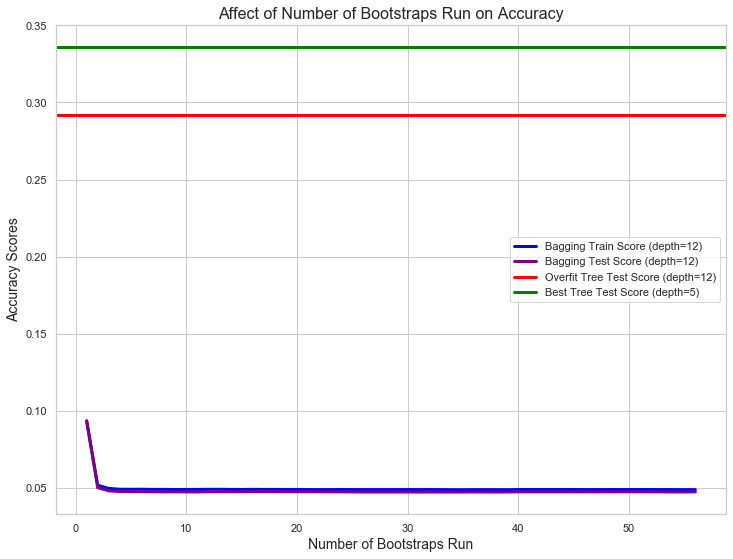

In [20]:
# convert dataframe back to numpy array (why not just return this from the bagger function)
# using values rather than to_numpy (compatible with older ver) (https://stackoverflow.com/questions/54424818)
bagging_train_array = bagging_train_df.values
bagging_test_array = bagging_test_df.values

# call running_predictions on created numpy arrays
bagging_train_predictions = running_predictions(bagging_train_array, y_train)
bagging_test_predictions = running_predictions(bagging_test_array, y_test)

# bootstrap number as a list from the range (https://stackoverflow.com/questions/18265935)
numbootstaps = list(range(1, n_trees + 2))

plt.figure(figsize=(12,9))

# plot data
plt.plot(numbootstaps, bagging_train_predictions, label='Bagging Train Score (depth=12)', linewidth=3, color='blue')
plt.plot(numbootstaps, bagging_test_predictions, label='Bagging Test Score (depth=12)', linewidth=3, color='purple')
plt.axhline(y=overfit_cv_tree_test_score, label='Overfit Tree Test Score (depth=12)', linewidth=3, color='red')
plt.axhline(y=best_cv_tree_test_score, label='Best Tree Test Score (depth=5)', linewidth=3, color='green')

# plot formatting
plt.xlabel('Number of Bootstraps Run', fontsize=14)
plt.ylabel('Accuracy Scores', fontsize=14)
plt.title('Affect of Number of Bootstraps Run on Accuracy', fontsize=16)
plt.legend()

plt.show()

# Random Forests

In [21]:
# (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
random_forest = RandomForestClassifier(n_estimators=n_trees, max_depth=13, max_features='sqrt')
random_forest.fit(X_train, y_train)

# predict train and test
random_forest_train_pred = random_forest.predict(X_train)
random_forest_test_pred = random_forest.predict(X_test)

# accuracy score for train and test
random_forest_train_score = accuracy_score(y_train, random_forest_train_pred)
random_forest_test_score = accuracy_score(y_test, random_forest_test_pred)

print('Accuracy of random forest model (Train): ', random_forest_train_score)
print('Accuracy of random forest model (Test): ', random_forest_test_score)

Accuracy of random forest model (Train):  0.4243954126153079
Accuracy of random forest model (Test):  0.350068561455996


Comparison of Top Predictors

In [22]:
top_predictors_rf_list = []
for t in range(n_trees):
    top_predictors_rf_list.append(random_forest.estimators_[t].tree_.feature[0])

# (https://www.geeksforgeeks.org/creating-a-pandas-series-from-lists/)
top_predictors_rf = pd.Series(top_predictors_rf_list) 
 
    
top_predictors_bagging_list = []
for t in range(n_trees):
    top_predictors_bagging_list.append(bagging_models[t].tree_.feature[0])

# (https://www.geeksforgeeks.org/creating-a-pandas-series-from-lists/)    
top_predictors_bagging = pd.Series(top_predictors_bagging_list)

# frequency of values in series (geeksforgeeks.org/python-pandas-series-value_counts/)
print('Top Predictors in Random Forest Trees:')
print(top_predictors_rf.value_counts())
print()
print('Top Predictors in Bagging Decision Trees:')
print(top_predictors_bagging.value_counts())

Top Predictors in Random Forest Trees:
32    13
31     5
1      5
37     4
36     4
30     4
40     3
33     3
27     2
35     2
41     2
25     2
2      1
42     1
28     1
29     1
38     1
0      1
dtype: int64

Top Predictors in Bagging Decision Trees:
32    55
dtype: int64


Random forest randomly selects a subset of predictors to split on. Therefore the first split can vary based on what subset of predictors is being used. Bagging does not subset the predictors so is always using the same best predictor.

Random forest can possibly capture more variance in the data because it is aggregating trees that are more varied. Theoretically random forest should therefore be able to get higher accuracies than bagging.

Accuracy Comparison:

In [23]:
# setup all list needed to create dataframe
results_cols = ['classifier', 'train accuracy', 'test accuracy']
results_classifier = ['single tree with best depth chosen by CV', 'single depth-X tree', 
                      'bagging 55 depth-X trees', 'random forest of 55 depth-X trees']
results_train_accuracy = [best_cv_tree_train_score, overfit_cv_tree_train_score, 
                          bagging_accuracy_train, random_forest_train_score]
results_test_accuracy = [best_cv_tree_test_score, overfit_cv_tree_test_score, 
                         bagging_accuracy_test, random_forest_test_score]

# dataframe from dictionary (https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/)
results_dict = {results_cols[0]: results_classifier,
               results_cols[1]: results_train_accuracy,
               results_cols[2]: results_test_accuracy,}

# create dataframes from all results above
results_df = pd.DataFrame(results_dict)

results_df

,classifier,train accuracy,test accuracy
0,single tree with best depth chosen by CV,0.362215,0.335826
1,single depth-X tree,0.887855,0.292165
2,bagging 55 depth-X trees,0.048718,0.047245
3,random forest of 55 depth-X trees,0.424395,0.350069


# Boosting

In [24]:
tree1 = DecisionTreeClassifier(max_depth=3)  
tree1.fit(X_train, y_train)

tree1_train_pred = tree1.predict(X_train) 
tree1_test_pred = tree1.predict(X_test) 

# using accuracy_score rather than model.score(X,y) because have predictions
tree1_train_score = accuracy_score(y_train, tree1_train_pred)
tree1_test_score = accuracy_score(y_test, tree1_test_pred)

print('Accuracy of tree1 model (Train):', tree1_train_score)
print('Accuracy of tree1 model (Test): ', tree1_test_score) 

Accuracy of tree1 model (Train): 0.2962634006482174
Accuracy of tree1 model (Test):  0.2981800049862877


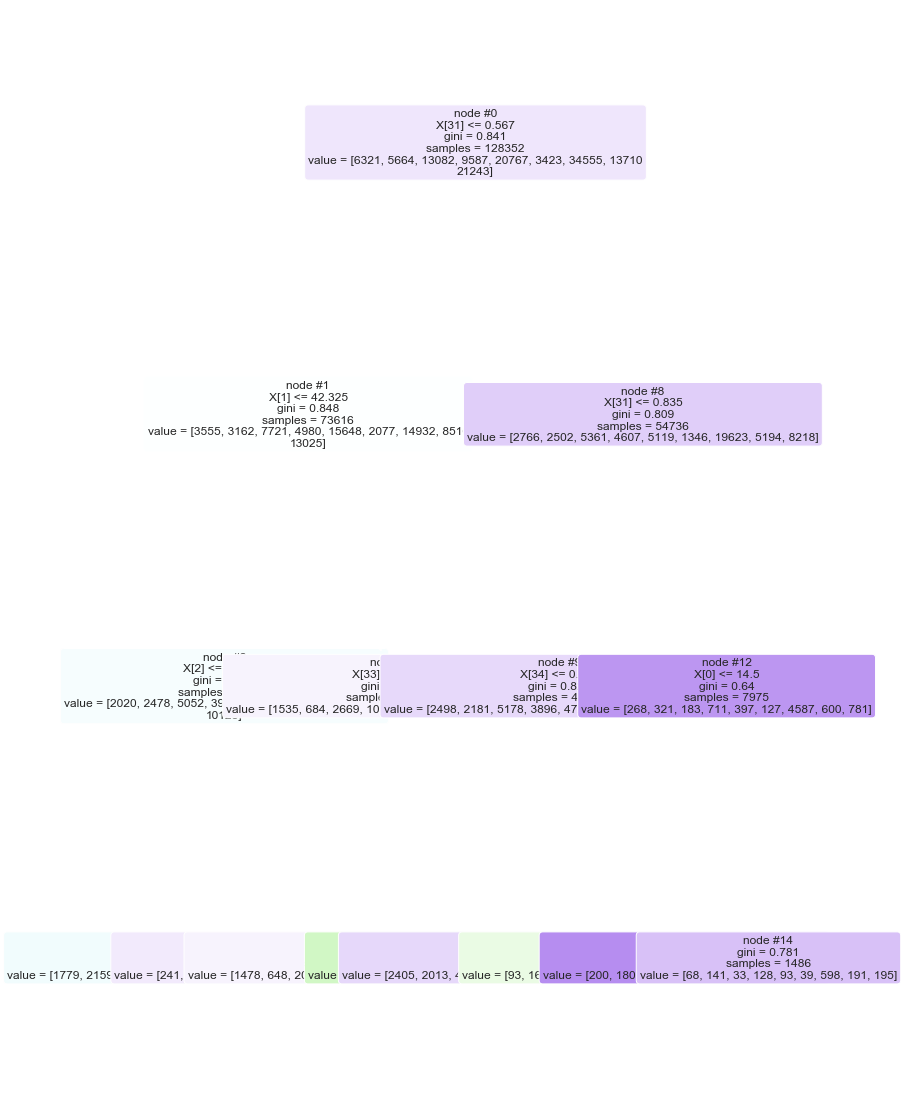

In [25]:
from sklearn import tree

plt.figure(figsize=(12,20))
tree.plot_tree(tree1, filled=True, impurity=True, node_ids=True, rounded=True, fontsize=12, max_depth = 3)
plt.show()

In [26]:
display (tree1.feature_importances_)
display (tree1.tree_.value)
display (tree1.tree_.feature)

array([0.02658832, 0.09389749, 0.03789362, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.70207222, 0.        , 0.05717489, 0.08237346,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

array([[[6.3210e+03, 5.6640e+03, 1.3082e+04, 9.5870e+03, 2.0767e+04,
         3.4230e+03, 3.4555e+04, 1.3710e+04, 2.1243e+04]],

       [[3.5550e+03, 3.1620e+03, 7.7210e+03, 4.9800e+03, 1.5648e+04,
         2.0770e+03, 1.4932e+04, 8.5160e+03, 1.3025e+04]],

       [[2.0200e+03, 2.4780e+03, 5.0520e+03, 3.9690e+03, 1.3311e+04,
         1.5510e+03, 1.1163e+04, 6.7570e+03, 1.0128e+04]],

       [[1.7790e+03, 2.1590e+03, 4.0710e+03, 3.4360e+03, 1.2123e+04,
         1.3600e+03, 9.3430e+03, 5.9050e+03, 9.1180e+03]],

       [[2.4100e+02, 3.1900e+02, 9.8100e+02, 5.3300e+02, 1.1880e+03,
         1.9100e+02, 1.8200e+03, 8.5200e+02, 1.0100e+03]],

       [[1.5350e+03, 6.8400e+02, 2.6690e+03, 1.0110e+03, 2.3370e+03,
         5.2600e+02, 3.7690e+03, 1.7590e+03, 2.8970e+03]],

       [[1.4780e+03, 6.4800e+02, 2.0210e+03, 9.6000e+02, 2.2670e+03,
         4.8000e+02, 3.4840e+03, 1.6390e+03, 2.6890e+03]],

       [[5.7000e+01, 3.6000e+01, 6.4800e+02, 5.1000e+01, 7.0000e+01,
         4.6000e+01, 2.8500e

array([31,  1,  2, -2, -2, 33, -2, -2, 31, 34, -2, -2,  0, -2, -2],
      dtype=int64)

In [27]:
# get samples at each leaf (https://datascience.stackexchange.com/questions/21794)
tree1.apply(X_train)

array([10, 10,  6, ..., 10,  3,  3], dtype=int64)

In [28]:
tree1.decision_path(X_train)

<128352x15 sparse matrix of type '<class 'numpy.int64'>'
	with 513408 stored elements in Compressed Sparse Row format>

In [29]:
tree1.tree_.__getstate__()

{'max_depth': 3,
 'node_count': 15,
 'nodes': array([( 1,  8, 31,  5.66693604e-01, 0.841489  , 128352, 128352.),
        ( 2,  5,  1,  4.23254623e+01, 0.84843808,  73616,  73616.),
        ( 3,  4,  2, -7.10615196e+01, 0.84174179,  56429,  56429.),
        (-1, -1, -2, -2.00000000e+00, 0.83936753,  49294,  49294.),
        (-1, -1, -2, -2.00000000e+00, 0.84457284,   7135,   7135.),
        ( 6,  7, 33,  3.52931350e-01, 0.85646219,  17187,  17187.),
        (-1, -1, -2, -2.00000000e+00, 0.8572451 ,  15666,  15666.),
        (-1, -1, -2, -2.00000000e+00, 0.75233645,   1521,   1521.),
        ( 9, 12, 31,  8.35123360e-01, 0.80925867,  54736,  54736.),
        (10, 11, 34,  6.45186529e-02, 0.82654937,  46761,  46761.),
        (-1, -1, -2, -2.00000000e+00, 0.82344834,  43636,  43636.),
        (-1, -1, -2, -2.00000000e+00, 0.80248893,   3125,   3125.),
        (13, 14,  0,  1.45000000e+01, 0.63996984,   7975,   7975.),
        (-1, -1, -2, -2.00000000e+00, 0.59727128,   6489,   6489.),
   

# ADA Boost Classifier

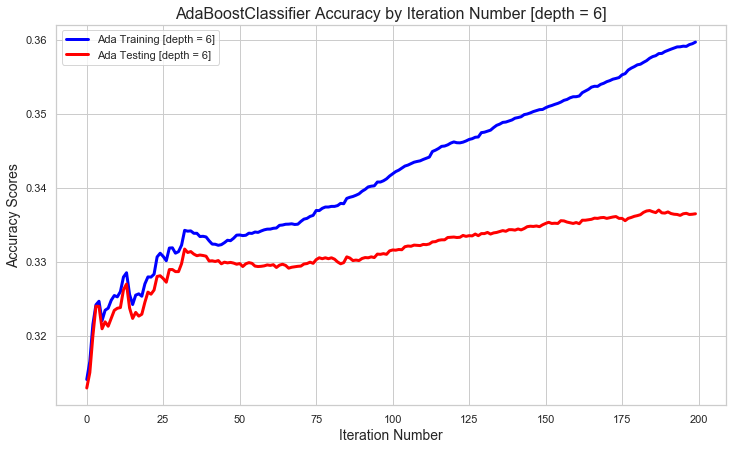

In [30]:
iter = 200
rate = 0.05

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=iter, learning_rate=rate)
ada.fit(X_train,y_train)

# thank you for the hints (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
ada_train_scores = list(ada.staged_score(X_train, y_train))
ada_test_scores = list(ada.staged_score(X_test, y_test))

# plot data
plt.figure(figsize=(12,7))
plt.plot(ada_train_scores, label='Ada Training [depth = 6]', linewidth=3, color='blue')
plt.plot(ada_test_scores, label='Ada Testing [depth = 6]', linewidth=3, color='red')

# plot formatting
plt.xlabel('Iteration Number', fontsize=14)
plt.ylabel('Accuracy Scores', fontsize=14)
plt.title('AdaBoostClassifier Accuracy by Iteration Number [depth = 6]', fontsize=16)
plt.legend()

plt.show()

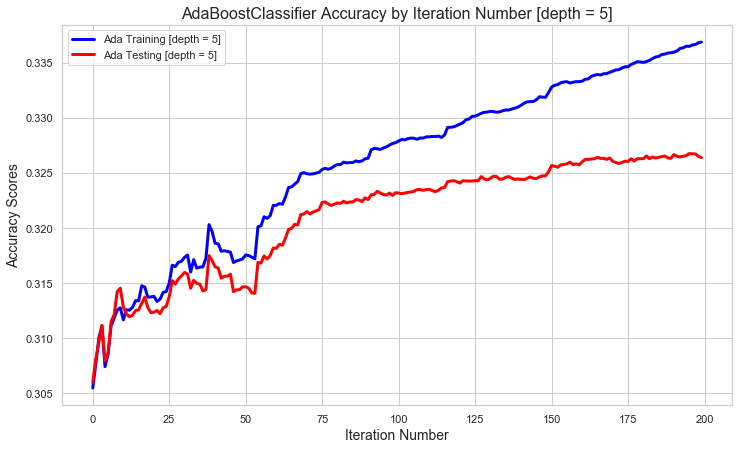

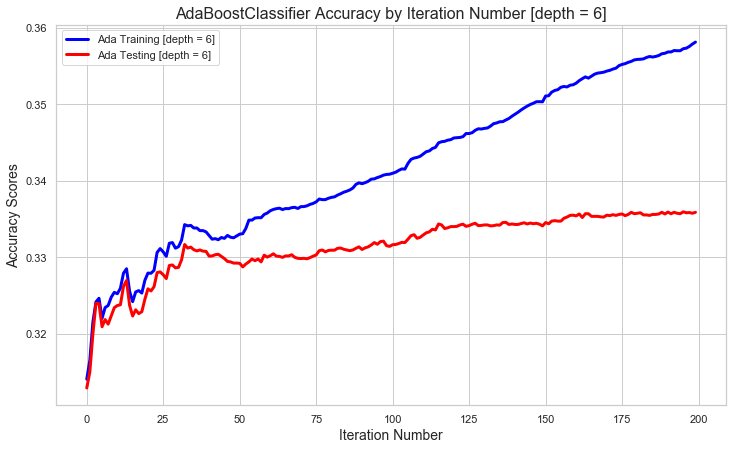

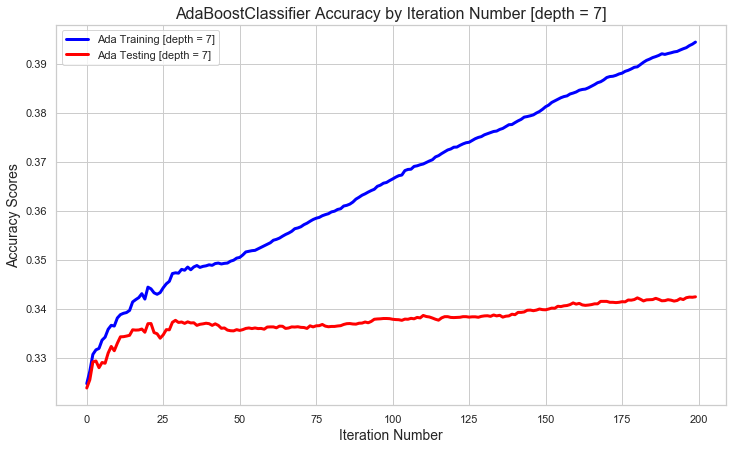

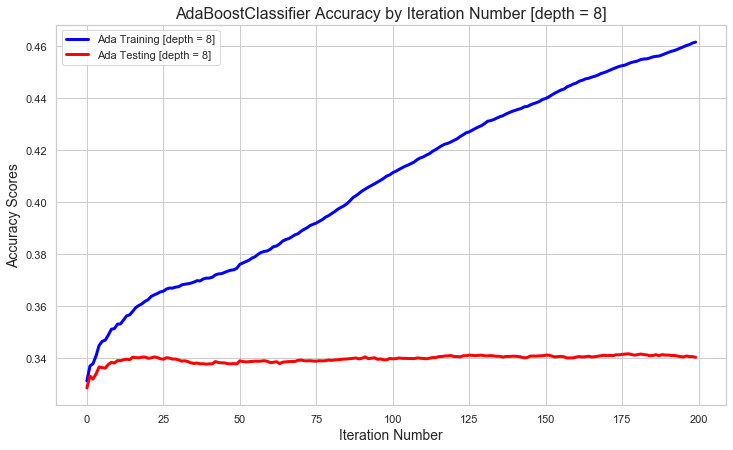

In [31]:
iter = 200
rate = 0.05
depths = [5,6,7,8]

for d in depths:
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=iter, learning_rate=rate)
    ada.fit(X_train,y_train)

    # thank you for the hints (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
    ada_train_scores = list(ada.staged_score(X_train, y_train))
    ada_test_scores = list(ada.staged_score(X_test, y_test))

    # plot data
    plt.figure(figsize=(12,7))
    plt.plot(ada_train_scores, label='Ada Training [depth = %i]' %d, linewidth=3, color='blue')
    plt.plot(ada_test_scores, label='Ada Testing [depth = %i]' %d, linewidth=3, color='red')

    # plot formatting
    plt.xlabel('Iteration Number', fontsize=14)
    plt.ylabel('Accuracy Scores', fontsize=14)
    # add variable to title (https://stackoverflow.com/questions/43757820)
    plt.title('AdaBoostClassifier Accuracy by Iteration Number [depth = %i]' %d, fontsize=16)
    plt.legend()

    plt.show()

The lower tree depths require more boosting iterations to reach the best accuracies that are not overfit. Though, in this case the max accuracies are similar at depth=5 does have a lower max accuracy even after 200 iterations (with data where the first predictor is only marginally better this will be more pronounced). The higher the tree depth the lower the number of iterations where boosting starts to overfit.

The test accuracy mostly remains between 0.30-0.46 but as the depth increases the max training accuracy gets closer and closer to 1.0. At higher depths, boosting is greatly overfitting the training data.

In [32]:
# ada boost predictions change with each run
# the following params gave good similar results in train and test (not overfitting)
iter = 35
rate = 0.05
depths = 6

ada_best = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=iter, learning_rate=rate)
ada_best.fit(X_train,y_train)

# get the score for the model
ada_best_train_score = ada_best.score(X_train, y_train)
ada_best_test_score = ada_best.score(X_test, y_test)

print('Accuracy of best ada model (Train):      ', ada_best_train_score)
print('Accuracy of best ada model (Test):       ', ada_best_test_score) 

Accuracy of best ada model (Train):       0.37110446272749936
Accuracy of best ada model (Test):        0.34028297182747447


In [33]:
# all accuracy print statements from earlier in the notebook
print('Single Tree Best Depth CV [depth= 5] (Train):  ', best_cv_tree_train_score)
print('                                     (Test) :  ', best_cv_tree_test_score)   
print()
print('Single Overfit Tree Model [depth=12] (Train):  ', overfit_cv_tree_train_score)
print('                                     (Test) :  ', overfit_cv_tree_test_score)   
print()
print('Overfit Tree with Bagging [depth=12] (Train):  ', bagging_accuracy_train)
print('                          [trees=55] (Test) :  ', bagging_accuracy_test)
print()
print('Random Forest Model       [depth=12] (Train):  ', random_forest_train_score)
print('                          [trees=55] (Test) :  ', random_forest_test_score)
print()
print('Ada Boost Best Model      [depth= 6] (Train):  ', ada_best_train_score)
print('                          [iters=35] (Test) :  ', ada_best_test_score) 

Single Tree Best Depth CV [depth= 5] (Train):   0.36221484667165293
                                     (Test) :   0.33582647718773373

Single Overfit Tree Model [depth=12] (Train):   0.887855272999252
                                     (Test) :   0.29216529543754677

Overfit Tree with Bagging [depth=12] (Train):   0.0487175891298928
                          [trees=55] (Test) :   0.04724507604088756

Random Forest Model       [depth=12] (Train):   0.4243954126153079
                          [trees=55] (Test) :   0.350068561455996

Ada Boost Best Model      [depth= 6] (Train):   0.37110446272749936
                          [iters=35] (Test) :   0.34028297182747447


As discussed earlier, at lower depths the tree isn't capturing enough variance so even boosting for a large number of iterations does not give max accuracy. At higher iterations and higher depths, boosting results in overfitting. At the depth and iterations choosen the accuracy in test is near it's max and does not differ from the training accuracy too much.

# Results Analysis for Best Model: Random Forest

In [34]:
#rf_best_rain_pred =

random_forest_best_train_pred = random_forest.predict(X_train)
random_forest_best_test_pred = random_forest.predict(X_test)

random_forest_best_train_pred_prob  = random_forest.predict_proba(X_train_scaled)
random_forest_best_test_pred_prob = random_forest.predict_proba(X_test_scaled)

#ada_boost_best_train_pred  = ada_best.predict(X_train)
#ada_boost_best_test_pred = ada_best.predict(X_test)

# ada_boost_best_train_pred_prob  = ada_best.predict_proba(X_train_scaled)
# ada_boost_best_test_pred_prob = ada_best.predict_proba(X_test_scaled)

In [35]:
def summarize_predictions(predictions_train, predictions_test):
    """
    Generates a summary table of the training and test predictions, showing count
    and proportion by class
    
    predictions_train: np.array, the predicted classes generated on the training data
    predictions_test:np.array, the predicted classes generated on the test data
    
    returns: tuple of 2 pd.DataFrame objects, one summarizing the training predictions
             the other summarizing the test predictions
    """
    frame_name_list = ['pred_counts_train', 'pred_counts_test']
    
    for predictions, name in zip(
        [predictions_train, predictions_test],
        frame_name_list
    ):
        locals()[name] = np.array(np.unique(predictions, return_counts=True)).T
        locals()[name] = np.hstack(
            [locals()[name], locals()[name][:,1].reshape(-1,1)/np.sum(locals()[name][:,1])]
        )
        locals()[name] = pd.DataFrame(locals()[name], columns=['class', 'count', 'proportion'])
        locals()[name][['class', 'count']] = locals()[name][['class', 'count']].astype(int)
        locals()[name] = locals()[name].set_index('class')

    return locals()[frame_name_list[0]], locals()[frame_name_list[1]]

In [36]:
random_forest_best_train_pred_summary, random_forest_best_test_pred_summary = summarize_predictions(
    random_forest_best_train_pred, 
    random_forest_best_test_pred)

#print('Training Predictions:\n', ada_boost_train_pred_summary)
print('Training Predictions:\n', random_forest_best_train_pred_summary)


print('\n\n')
#print('Testing Predictions:\n', ada_boost_test_pred_summary)
print('Testing Predictions:\n', random_forest_best_test_pred_summary)

Training Predictions:
        count  proportion
class                   
0       1920    0.014959
1        285    0.002220
2       8310    0.064744
3        515    0.004012
4      42672    0.332461
5         61    0.000475
6      63615    0.495629
7       1195    0.009310
8       9779    0.076189



Testing Predictions:
        count  proportion
class                   
0        406    0.012653
1         26    0.000810
2       2090    0.065133
3         43    0.001340
4      10742    0.334767
5          3    0.000093
6      16372    0.510222
7        154    0.004799
8       2252    0.070182


# Confusion matrices

In [37]:
def make_conf_matrix(predictions, y_actual):
    """
    Generates a confusion matrix of actual classes versus predicted classes
    
    predictions: np.array, predicted class values generated by the model
    y_actual: np.array, actual class values
    
    returns: pd.DataFrame, the resulting confusion matrix with marginal totals included
    """
    class_labels = sorted(list(set(y_actual)))
    
    conf_matrix = pd.DataFrame(confusion_matrix(predictions, y_actual), columns=class_labels)
    conf_matrix.index.name = 'Predicted'
    conf_matrix.columns.name = 'Actual'
    conf_matrix.loc['Total'] = conf_matrix.sum(axis=0)
    conf_matrix['Total'] = conf_matrix.sum(axis=1)
    
    return conf_matrix

In [38]:
print('Confusion Matrix for Random Forest(Testing):\n')
rf_conf_matrix = make_conf_matrix(random_forest_best_test_pred,y_test)

rf_conf_matrix

Confusion Matrix for Random Forest(Testing):



Actual,0,1,2,3,4,5,6,7,8,Total
Predicted,,,,,,,,,,
0,179,7,34,17,39,6,45,29,50,406
1,3,10,0,0,0,0,9,2,2,26
2,103,16,1240,80,120,38,189,80,224,2090
3,0,0,3,20,2,4,7,4,3,43
4,409,479,701,661,2961,285,1868,1341,2037,10742
5,0,0,0,0,0,2,0,1,0,3
6,719,821,1130,1494,1739,414,6082,1692,2281,16372
7,3,8,6,12,19,5,35,46,20,154
8,164,75,157,113,312,102,404,232,693,2252


In [39]:
def generate_class_metrics(conf_matrix):
    """
    Generates a dataframe of the various by-class classification metrics that
    can be calculated directly from a confusion matrix, such as True Positive Rate,
    False Negative Rate, etc.
    
    conf_matrix: pd.DataFrame, generated with the make_conf_matrix function
    
    returns: pd.DataFrame, each row representing a different class, each
             column a different classification metric for each class
    """
    # rename index
    conf_matrix = conf_matrix.copy()
    conf_matrix.index.name = 'class'
    conf_matrix.columns.name = 'class'
    results = dict()
    
    # True Pos, False Pos, False Neg, True Neg counts
    results['TP'] = pd.Series(np.diag(conf_matrix.iloc[:-1,:-1]))
    results['TP'].index.name = 'class'
    results['FP'] = conf_matrix.iloc[:-1,:-1].sum(axis=1) - results['TP']  
    results['FN'] = conf_matrix.iloc[:-1,:-1].sum(axis=0) - results['TP']
    results['TN'] = conf_matrix.iloc[:-1,:-1].values.sum() -\
                    (results['FP'] + results['FN'] + results['TP'])

    # true positive rate
    results['TPR'] = results['TP']/(results['TP']+results['FN'])
    # false negative rate
    results['FNR'] = results['FN']/(results['TP']+results['FN'])
    # false positive rate
    results['FPR'] = results['FP']/(results['FP']+results['TN'])
    # true negative rate
    results['TNR'] = results['TN']/(results['TN']+results['FP']) 
    # positive predictive value
    results['PPV'] = results['TP']/(results['TP']+results['FP'])
    # negative predictive value
    results['NPV'] = results['TN']/(results['TN']+results['FN'])
    
    # convert results dictionary to a dataframe 
    results_df = pd.concat(
        [
            # first separate the integer values so they format correctly
            pd.DataFrame(
                list(results.values())[:4],
                index=list(results.keys())[:4]
            ).T,
            # followed by the float values
            pd.DataFrame(
                list(results.values())[4:],
                index=list(results.keys())[4:]
            ).T
        ], axis=1
    )
    
    return results_df

In [40]:
generate_class_metrics(rf_conf_matrix)

,TP,FP,FN,TN,TPR,FNR,FPR,TNR,PPV,NPV
class,,,,,,,,,,
0,179,227,1401,30281,0.113291,0.886709,0.007441,0.992559,0.440887,0.955779
1,10,16,1406,30656,0.007062,0.992938,0.000522,0.999478,0.384615,0.956147
2,1240,850,2031,27967,0.379089,0.620911,0.029496,0.970504,0.593301,0.932295
3,20,23,2377,29668,0.008344,0.991656,0.000775,0.999225,0.465116,0.925823
4,2961,7781,2231,19115,0.570300,0.429700,0.289300,0.710700,0.275647,0.895484
5,2,1,854,31231,0.002336,0.997664,0.000032,0.999968,0.666667,0.973383
6,6082,10290,2557,13159,0.704017,0.295983,0.438825,0.561175,0.371488,0.837300
7,46,108,3381,28553,0.013423,0.986577,0.003768,0.996232,0.298701,0.894125
8,693,1559,4617,25219,0.130508,0.869492,0.058219,0.941781,0.307726,0.845254


# Create value count summary tables by crime-type for later reference

In [41]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

class_dict = dict(
    zip(crime_types_test.reset_index()['crime-type'], crime_types_test.reset_index()['crime-type-cat'])
)

In [42]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

The number of observed crime type classes in both the training and test set are:

TRAINING
                                   count  proportion
crime-type crime-type-cat                           
0          other                    6321    0.049247
1          burglary                 5664    0.044129
2          drugs-substances        13082    0.101923
3          fraud                    9587    0.074693
4          harassment-disturbance  20767    0.161797
5          robbery                  3423    0.026669
6          theft                   34555    0.269221
7          vandalism-property      13710    0.106816
8          violence-aggression     21243    0.165506


TEST
                                   count  proportion
crime-type crime-type-cat                           
0          other                    1580    0.049240
1          burglary                 1416    0.044129
2          drugs-substances         3271    0.101938
3          fraud                    2397    0.074701
4

# Calculate and Plot AUC

In [43]:
##################################################################
# DEFINE FUNCTIONS FOR CALCULATING ROC AND AUC AND PLOTTING CURVES
##################################################################

# MULTI-CLASS AUC REQUIRES scikit-learn v0.22

def generate_roc_auc(y_values_actual, predicted_probabilities, class_dict):
    """
    Creates a dictionary of ROC curve values generated using
    sklearn.metrics.roc_curve for every outcome class in a multi-class
    problem
    
    NOTE: multi-class AUC requires scikit-learn>=v0.22
    y_values_actual: np.array, the 1-dimensional array containing the 
                     multi-classs true y values against which you are evaluating
                     the predicted probabilities (i.e. y_test)
    predicted_probabilities: np.array, the 2-dimensional array generated
                             using sklearn's "model.predict_proba()" method
                             (i.e. test set predicted probabilities)
                     
    returns: tuple(float, float, dict), (1) a float representing the average macro AUC
             for all classes, (2) a float representing the average weighted AUC (weighted
             by the number of true samples for each class to account for class imbalance)
             and (3) a dictionary of dictionaries, where each top level key represents a
             different y class, and the value for each y class key is a dictionary
             containing the corresponding frp, tpr, threshold, and individual class AUC
             values for that particular y class outcome. Example output format shown below:
             
             (
                 auc_average,
                 auc_weighted_average,
                 output_dict = {
                    0: {
                        'frp': np.array of shape (n,)
                        'tpr': np.array of shape (n,)
                        'threshold': np.array of shape (n,)
                        'auc': float of micro auc for individual class
                        'name': str name of class
                    }
                    1: {
                        'frp': ...
                        ...
                    }
                    ...
                 }
            )
    """
    # create sorted list of all class labels
    class_labels = sorted(list(set(y_values_actual)))

    # convert y_values to binary indicators for each class and store as 2D
    # array of dimensions (n_classes, n_y_values), with each row containing one
    # set of class indicators
    y_class_array = np.vstack(
        [
            (y_values_actual==class_val).astype(int) for class_val in class_labels
        ]
    )

    # create roc curve dictionary
    roc_curve_dict = {
        crime_class: {
            key: value
            for key, value in zip(
                ['fpr', 'tpr', 'thresholds'],
                roc_curve(y_class, predicted_probs_class)
            )
        } for (crime_class, predicted_probs_class), y_class in zip(
            enumerate(predicted_probabilities.T),
            y_class_array
        )
    }
    
    # add individual class auc's and class names to dictionary
    for crime_class in class_labels:
        roc_curve_dict[crime_class]['auc'] = roc_auc_score(
            y_class_array[crime_class],
            predicted_probabilities[:,crime_class]
        )
        roc_curve_dict[crime_class]['name'] = class_dict[crime_class]
    
    # generate overall average auc's for all classes, weighted and unweighted
    auc_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='macro'
    )
    auc_weighted_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='weighted'
    )
    
    return auc_avg, auc_weighted_avg, roc_curve_dict

In [44]:
rf_auc_avg, rf_weighted_auc_avg, rf_roc_curve = generate_roc_auc(y_test, random_forest_best_test_pred_prob, class_dict)

#ada_boost_best_test_pred_prob

print('Random Forest AUC Average:\n', rf_auc_avg)
print('\n')
print('Random Forest Weighted AUC Average:\n', rf_weighted_auc_avg)

Random Forest AUC Average:
 0.5404020005097443


Random Forest Weighted AUC Average:
 0.561008492251532


In [45]:
def plot_roc_all_classes(overall_auc, overall_auc_weighted, roc_curve_dict,
                         title='ROC plotted for all crime type TEST classes',
                         savepath=None):
    """
    Generates a plot of ROC curves for all responses classes
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc'
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the
              "filepath.png" string, indicating where you would like the image saved
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    plt.title(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100

    ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=1)

    for key in roc_curve_dict.keys():
        plt.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} : {:.3f}'.format(
                key,
                roc_curve_dict[key]['auc']
            )
        )
        plt.legend(
            fontsize=14,
            title='class : AUC',
            title_fontsize=14,
            edgecolor='k',
            framealpha=1,
            loc=4
        )

    ax.tick_params(labelsize=16)
    ax.set_ylabel("TRUE positive rate", fontsize=18)
    ax.set_xlabel("FALSE positive rate", fontsize=18)
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show();

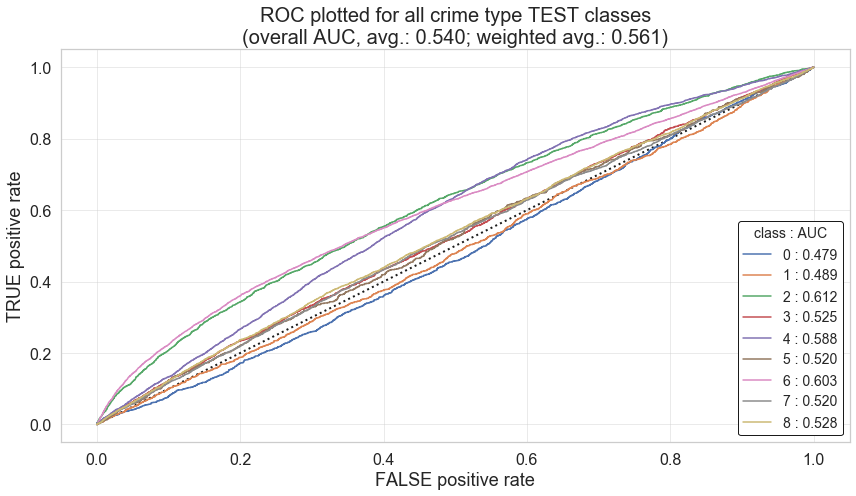

In [46]:
plot_roc_all_classes(rf_auc_avg, rf_weighted_auc_avg, rf_roc_curve)